## Задание

#### 1. Boosting

Варьируя параметры ансамбля в подходам блэндинг и стэкинг, обучить оптимальный классификатор.

Визуализировать графики зависимости предсказания от параметров модели.

#### 2. Trees

1. **Датасет Iris** - постройте и визуализируйте структуру решающего дерева для критерия разбиения “entropy"
2. **Датасет departure-delayed**:
    1. Обучите серию классификаторов без регуляризации по минимальному количеству экземпляров в листе. Визуализируйте MAE.
    2. Обучите дерево с наилучшими параметрами из предыдущего примера.
    3. Ансамбли (Bagging). Выбрать оптимальное количество регрессоров, оптимальные параметры для Bagging Regressor. Выбрать оптимальные параметры для каждого дерева.
    4. Случайный лес (Random Forest). Обучить, выявить оптимальное количество моделей в регрессоре, оптимальные параметры для регрессора.

## Решение

### Импорт

In [60]:
from datasets import load_dataset

import nltk
from nltk.corpus import stopwords

from sklearn.feature_extraction.text import CountVectorizer, TfidfTransformer
from sklearn.model_selection import KFold, GridSearchCV, train_test_split
from sklearn.ensemble import BaggingRegressor, RandomForestClassifier, RandomForestRegressor
from sklearn.metrics import accuracy_score, mean_absolute_error
from sklearn.datasets import load_iris

from sklearn import tree
from sklearn.tree import DecisionTreeClassifier, DecisionTreeRegressor

import pandas as pd
import numpy as np

import matplotlib.pyplot as plt

import os

### Настройки

In [2]:
RANDOM_STATE = 42

# Папка лабораторной
DIR_LAB = 'Lab6'

# Папка для загруженных данных
DIR_DATA = 'data'

DIR_TREES_DATA = 'departure-delayed'

# Файлы с данными
FILE_BOOSTING_DATA_TRAIN = 'train.jsonl'
FILE_BOOSTING_DATA_TEST = 'validation.jsonl'

FILE_TREES_DATA_TRAIN_X = 'train_features.csv'
FILE_TREES_DATA_TRAIN_Y = 'train_target.csv'

In [3]:
PATH_BOOSTING_DATA_TRAIN = os.path.join(DIR_LAB, DIR_DATA, FILE_BOOSTING_DATA_TRAIN)
PATH_BOOSTING_DATA_TEST  = os.path.join(DIR_LAB, DIR_DATA, FILE_BOOSTING_DATA_TEST)

PATH_TREES_DATA_TRAIN_X = os.path.join(DIR_LAB, DIR_DATA, DIR_TREES_DATA, FILE_TREES_DATA_TRAIN_X)
PATH_TREES_DATA_TRAIN_Y  = os.path.join(DIR_LAB, DIR_DATA, DIR_TREES_DATA, FILE_TREES_DATA_TRAIN_Y)

### 1. Boosting

#### Функции

In [86]:
def draw_score_graph(results : pd.DataFrame, x_col, y_col, group_col, name=None, x_col_name=None, y_col_name=None, group_col_name=None):
    groups = results.groupby(by=[group_col, x_col])[y_col].mean().reset_index().groupby(by=[group_col])

    for k in groups.groups:
        df_group = groups.get_group(k)

        plt.plot(df_group[x_col], df_group[y_col], label=f'{group_col if group_col_name is None else group_col_name} = {k}')

    plt.xlabel(x_col_name if x_col_name is not None else x_col)
    plt.ylabel(y_col_name if y_col_name is not None else y_col)

    if name is not None:
        plt.title(name)
    
    plt.legend()
    plt.show()

#### Данные

##### Загружаем данные

In [4]:
dataset = load_dataset('json', data_files={'train': PATH_BOOSTING_DATA_TRAIN,'test': PATH_BOOSTING_DATA_TEST})

##### Векторизуем

In [5]:
vectorizer = CountVectorizer(max_features=500, min_df=4, max_df=0.7, stop_words=stopwords.words('english'))

X_train_vec = vectorizer.fit_transform(dataset['train']['text'])
vocabulary = vectorizer.get_feature_names_out()

##### TF-IDF

In [6]:
tfidf = TfidfTransformer()
X_train_idf = tfidf.fit_transform(X_train_vec)

X_test_vec = vectorizer.transform(dataset['test']['text'])
X_test_idf = tfidf.transform(X_test_vec)

##### Формируем обучающую и тестовую выборки

In [7]:
X_train, X_test, y_train, y_test = X_train_idf.toarray(), X_test_idf.toarray(), dataset['train']['label'], dataset['test']['label']

X_train_0, X_train_1, y_train_0, y_train_1 = train_test_split(X_train, y_train, test_size=0.33, random_state=RANDOM_STATE)

#### Blending

In [9]:
def make_blending_prediction(basic_clfs, final_clf, X):
    by = []
    for c in basic_clfs:
        by.append(c.predict(X))
    by_t = np.array(by).transpose()
    return final_clf.predict(by_t)

In [27]:
def test_blending_estimators(n_basics, basic_n_estimators, basic_max_depth, final_n_estimators, final_max_depth, X_train_0, X_train_1, X_test, y_train_0, y_train_1, y_test):
    results = []

    for ine in basic_n_estimators:
        for imd in basic_max_depth:
            basic_clfs = []
            by_pred = []

            for i in range(1, n_basics + 1):
                basic_clf = RandomForestClassifier(n_estimators=ine, max_depth=imd, random_state=RANDOM_STATE*i)
                basic_clf.fit(X_train_0, y_train_0)

                by_pred.append(basic_clf.predict(X_train_1).reshape(len(X_train_1),1))

                basic_clfs.append(basic_clf)
            
            by_pred_t = np.array(by_pred).transpose()[0]

            for fne in final_n_estimators:
                for fmd in final_max_depth:
                    final_clf = RandomForestClassifier(n_estimators=fne, max_depth=fmd, random_state=RANDOM_STATE)
                    final_clf.fit(by_pred_t, y_train_1)

                    y_test_pred = make_blending_prediction(basic_clfs, final_clf, X_test)

                    #print(len(X_test), len(y_test), len(y_test_pred))

                    score = accuracy_score(y_test, y_test_pred)

                    results.append((ine, imd, fne, fmd, score))

    return results

In [11]:
basic_n_estimators = [2, 4, 8, 16]
basic_max_depth = [2, 4, 6, 8]

final_n_estimators = [4, 8, 16, 24]
final_max_depth = [2, 4, 6, 8]

In [28]:
blending_results = test_blending_estimators(10, basic_n_estimators, basic_max_depth, final_n_estimators, final_max_depth, X_train_0, X_train_1, X_test, y_train_0, y_train_1, y_test)

In [93]:
df_blending_results = pd.DataFrame(blending_results, columns=[('Basic', 'N estimators'), ('Basic', 'Max depth'), ('Final', 'N estimators'), ('Final', 'Max depth'), 'Accuracy'])

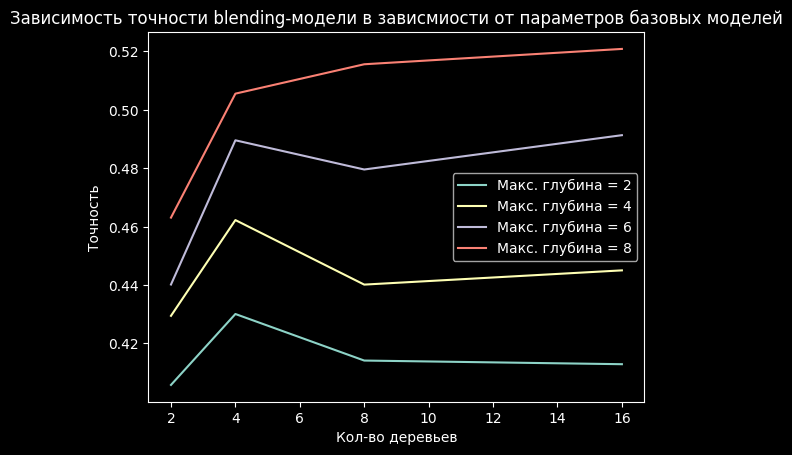

In [95]:
draw_score_graph(df_blending_results, ('Basic', 'N estimators'), 'Accuracy', ('Basic', 'Max depth'), name='Зависимость точности blending-модели в зависмиости от параметров базовых моделей', x_col_name='Кол-во деревьев', y_col_name='Точность', group_col_name='Макс. глубина')

#### Stacking

In [96]:
def make_stacking_predictions(basic_clfs, final_clf, data):
    y0 = []
    for c in basic_clfs:
        y0.append(c.predict(data))
    y0_t = np.array(y0).transpose()
    return final_clf.predict(y0_t)

In [108]:
def test_stacking_estimators(n_splits, basic_n_estimators, basic_max_depth, final_n_estimators, final_max_depth, X_train, X_test, y_train, y_test):
    results = []

    kf = KFold(n_splits=n_splits, shuffle=False) # random_state=RANDOM_STATE

    for ine in basic_n_estimators:
        for imd in basic_max_depth:
            basic_clfs = []
            pre_prediction = np.zeros((len(X_train), n_splits))

            for i, (train_index, test_index) in enumerate(kf.split(X_train)):
                X_train_0, X_train_1 = np.array(X_train)[train_index], np.array(X_train)[test_index]
                y_train_0, y_train_1 = np.array(y_train)[train_index], np.array(y_train)[test_index]

                basic_clf = RandomForestClassifier(n_estimators=ine, max_depth=imd, random_state=RANDOM_STATE*(i + 1))

                basic_clf.fit(X_train_0, y_train_0)

                pre_prediction[test_index, i] = basic_clf.predict(X_train_1)

                basic_clfs.append(basic_clf)

            for fne in final_n_estimators:
                for fmd in final_max_depth:
                    final_clf = RandomForestClassifier(n_estimators=fne, max_depth=fmd, random_state=RANDOM_STATE)
                    final_clf.fit(pre_prediction, y_train)

                    y_test_pred = make_stacking_predictions(basic_clfs, final_clf, X_test)

                    score = accuracy_score(y_test, y_test_pred)

                    results.append((ine, imd, fne, fmd, score))

    return results

In [98]:
basic_n_estimators = [2, 4, 8, 16]
basic_max_depth = [2, 4, 6, 8]

final_n_estimators = [4, 8, 16, 24]
final_max_depth = [2, 4, 6, 8]

In [109]:
stacking_results = test_stacking_estimators(10, basic_n_estimators, basic_max_depth, final_n_estimators, final_max_depth, X_train, X_test, y_train, y_test)

In [110]:
df_stacking_results = pd.DataFrame(stacking_results, columns=[('Basic', 'N estimators'), ('Basic', 'Max depth'), ('Final', 'N estimators'), ('Final', 'Max depth'), 'Accuracy'])

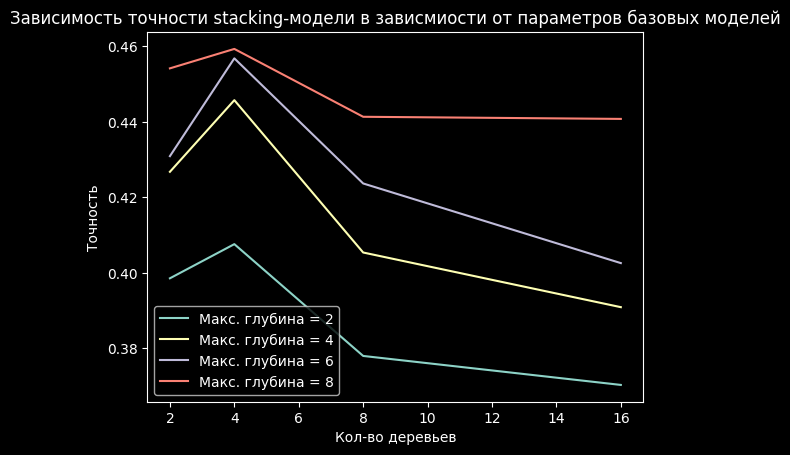

In [111]:
draw_score_graph(df_stacking_results, ('Basic', 'N estimators'), 'Accuracy', ('Basic', 'Max depth'), name='Зависимость точности stacking-модели в зависмиости от параметров базовых моделей', x_col_name='Кол-во деревьев', y_col_name='Точность', group_col_name='Макс. глубина')

### 2. Trees

#### 1. Iris

##### Данные

In [4]:
iris = load_iris()

X = iris.data[:, 2:] # petal length and width
y = iris.target

target_names = iris.target_names
feature_names = iris.feature_names[2:]

##### 1. Постройте и визуализируйте структуру решающего дерева для критерия разбиения “entropy"

[Text(0.4, 0.8333333333333334, 'x[0] <= 2.45\nentropy = 1.585\nsamples = 150\nvalue = [50, 50, 50]\nclass = setosa'),
 Text(0.2, 0.5, 'entropy = 0.0\nsamples = 50\nvalue = [50, 0, 0]\nclass = setosa'),
 Text(0.30000000000000004, 0.6666666666666667, 'True  '),
 Text(0.6, 0.5, 'x[1] <= 1.75\nentropy = 1.0\nsamples = 100\nvalue = [0, 50, 50]\nclass = versicolor'),
 Text(0.5, 0.6666666666666667, '  False'),
 Text(0.4, 0.16666666666666666, 'entropy = 0.445\nsamples = 54\nvalue = [0, 49, 5]\nclass = versicolor'),
 Text(0.8, 0.16666666666666666, 'entropy = 0.151\nsamples = 46\nvalue = [0, 1, 45]\nclass = virginica')]

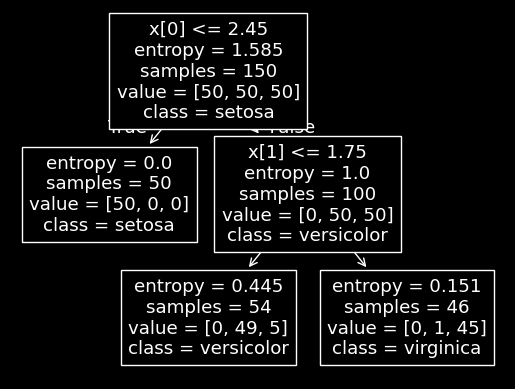

In [7]:
model_iris_tree = DecisionTreeClassifier(criterion='entropy', max_depth=2, random_state=RANDOM_STATE)
model_iris_tree.fit(X, y)

tree.plot_tree(model_iris_tree, class_names = target_names)

#### 2. Departure Delayed

##### Загрузка данных

In [17]:
dd_train = pd.read_csv(PATH_TREES_DATA_TRAIN_X).fillna(0)
dd_y = pd.read_csv(PATH_TREES_DATA_TRAIN_Y, index_col='id')

dd_train.drop('Year', axis=1, inplace=True)                 # Выкидываем год, т.к. он не несет вариативности в данные
real_cols = list(dd_train.dtypes[dd_train.dtypes != 'object'].index.values)     # Только столбцы с числовыми данными

In [47]:
X = dd_train[real_cols].to_numpy()
y = dd_y.to_numpy().ravel()

##### Разделение тренировочной выборки на тренировочную и валидационную

In [48]:
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=RANDOM_STATE)

##### Обучаем модели без регуляризации, варьируя минимальное количество экземпляров в листе

In [26]:
min_samples_leafs = [1, 2, 5, 10, 20, 50, 100, 200, 500, 1000, 1500]

In [36]:
mae_train = []
mae_val = []

best_mae = float('inf')
best_msl = None

for i, msl in enumerate(min_samples_leafs):
    print(f'{i} - {msl}: ', end='')

    dt = DecisionTreeRegressor(min_samples_leaf=msl, random_state=RANDOM_STATE)
    dt.fit(X_train, y_train)
    
    tmae = mean_absolute_error(dt.predict(X_train), y_train)
    vmae = mean_absolute_error(dt.predict(X_val), y_val)

    mae_train.append(tmae)
    mae_val.append(vmae)

    print(f'{tmae:.8f} - {vmae:.8f}')

    if vmae < best_mae:
        best_mae = vmae
        best_msl = msl

0 - 1: 0.00000000 - 43.40082096
1 - 2: 12.87478287 - 40.74534875
2 - 5: 22.41353056 - 37.03202531
3 - 10: 26.65848987 - 35.06191045
4 - 20: 29.20150556 - 33.84025819
5 - 50: 31.02138412 - 33.02984127
6 - 100: 31.77399175 - 32.83562496
7 - 200: 32.24852662 - 32.76852228
8 - 500: 32.70469403 - 32.90447206
9 - 1000: 32.91586848 - 33.02416024
10 - 1500: 33.03853999 - 33.11550756


In [38]:
print(f'Оптимальное число экземпляров в листе: {best_msl} (Validation MAE: {best_mae:.8f})')

Оптимальное число экземпляров в листе: 200 (Validation MAE: 32.76852228)


##### Визуализируем MAE

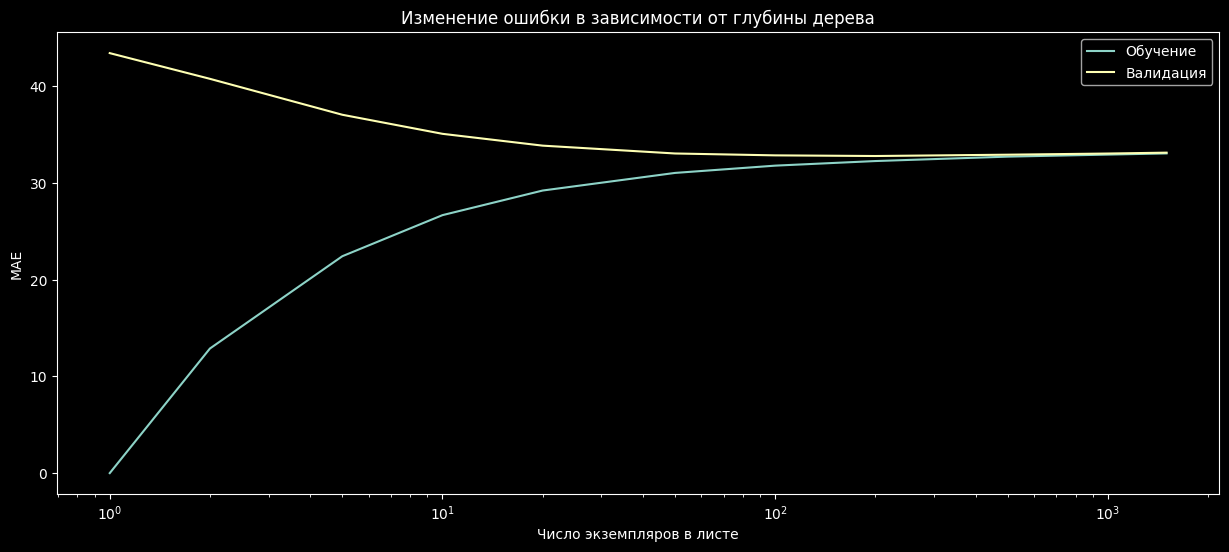

In [40]:
plt.figure(figsize=(15, 6))
plt.title('Изменение ошибки в зависимости от глубины дерева')

plt.plot(min_samples_leafs, mae_train, label='Обучение')
plt.plot(min_samples_leafs, mae_val, label='Валидация')
plt.legend()
plt.xlabel('Число экземпляров в листе')
plt.ylabel('MAE')
plt.xscale('log')
plt.show()

##### Обучаем модель с наилучшими параметрами

In [42]:
dd_best_tree = DecisionTreeRegressor(max_depth=21, min_samples_leaf=200, random_state=RANDOM_STATE)
dd_best_tree.fit(X_train, y_train)

dd_mae = mean_absolute_error(dd_best_tree.predict(X_val), y_val)

print(f'Validation MAE модели с наилучшими параметрами: {dd_mae:.8f}')

Validation MAE модели с наилучшими параметрами: 32.76565576


##### Ансамбли

Выбрать оптимальное количество регрессоров, оптимальные параметры для Bagging Regressor

In [44]:
bagging_param_grid = {
    'n_estimators': [2, 4, 6, 8],
    'max_samples': [0.4, 0.7, 1.0],
    'max_features': [0.4, 0.7, 1.0]
}

In [51]:
dd_bagging = BaggingRegressor(estimator=dd_best_tree, random_state=RANDOM_STATE)

bagging_grid_search = GridSearchCV(dd_bagging, bagging_param_grid, scoring='neg_mean_absolute_error', cv=3, verbose=3)
bagging_grid_search.fit(X_train, y_train)

Fitting 3 folds for each of 36 candidates, totalling 108 fits
[CV 1/3] END max_features=0.4, max_samples=0.4, n_estimators=2;, score=-33.384 total time=   1.4s
[CV 2/3] END max_features=0.4, max_samples=0.4, n_estimators=2;, score=-33.448 total time=   1.2s
[CV 3/3] END max_features=0.4, max_samples=0.4, n_estimators=2;, score=-33.485 total time=   1.2s
[CV 1/3] END max_features=0.4, max_samples=0.4, n_estimators=4;, score=-33.427 total time=   2.6s
[CV 2/3] END max_features=0.4, max_samples=0.4, n_estimators=4;, score=-33.485 total time=   2.6s
[CV 3/3] END max_features=0.4, max_samples=0.4, n_estimators=4;, score=-33.512 total time=   2.8s
[CV 1/3] END max_features=0.4, max_samples=0.4, n_estimators=6;, score=-33.441 total time=   4.1s
[CV 2/3] END max_features=0.4, max_samples=0.4, n_estimators=6;, score=-33.485 total time=   3.6s
[CV 3/3] END max_features=0.4, max_samples=0.4, n_estimators=6;, score=-33.511 total time=   3.8s
[CV 1/3] END max_features=0.4, max_samples=0.4, n_estima

GridSearchCV(cv=3,
             estimator=BaggingRegressor(estimator=DecisionTreeRegressor(max_depth=21,
                                                                        min_samples_leaf=200,
                                                                        random_state=42),
                                        random_state=42),
             param_grid={'max_features': [0.4, 0.7, 1.0],
                         'max_samples': [0.4, 0.7, 1.0],
                         'n_estimators': [2, 4, 6, 8]},
             scoring='neg_mean_absolute_error', verbose=3)

In [55]:
print('Лучшие параметры:')

for k, v in bagging_grid_search.best_params_.items():
    print(f'\t{k}: {v}')

print(f'MAE: {-bagging_grid_search.best_score_:.8f}')

Лучшие параметры:
	max_features: 1.0
	max_samples: 1.0
	n_estimators: 8
MAE: 32.70471266


In [56]:
dd_best_bagging = BaggingRegressor(estimator=dd_best_tree, random_state=RANDOM_STATE, **bagging_grid_search.best_params_)
dd_best_bagging.fit(X_train, y_train)

dd_bagging_mae = mean_absolute_error(dd_best_bagging.predict(X_val), y_val)

print(f'Validation MAE ансамбля: {dd_bagging_mae:.8f}')

Validation MAE ансамбля: 32.58711381


##### Случайный лес

Обучить, выявить оптимальное количество моделей в регрессоре, оптимальные параметры для регрессора

In [66]:
forest_param_grid = {
    'n_estimators': [4, 6, 8, 10],
    'max_depth': [None, 4, 6, 8],
    'max_features': [None, 'sqrt', 'log2']
}

In [67]:
dd_forest = RandomForestRegressor(criterion='squared_error',  random_state=RANDOM_STATE, n_jobs=-1)

forest_grid_search = GridSearchCV(dd_forest, forest_param_grid, scoring='neg_mean_absolute_error', cv=3, n_jobs=-1)
forest_grid_search.fit(X_train, y_train)

GridSearchCV(cv=3, estimator=RandomForestRegressor(n_jobs=-1, random_state=42),
             n_jobs=-1,
             param_grid={'max_depth': [None, 4, 6, 8],
                         'max_features': [None, 'sqrt', 'log2'],
                         'n_estimators': [4, 6, 8, 10]},
             scoring='neg_mean_absolute_error')

In [68]:
print('Лучшие параметры:')

for k, v in forest_grid_search.best_params_.items():
    print(f'\t{k}: {v}')

print(f'MAE: {-forest_grid_search.best_score_:.8f}')

Лучшие параметры:
	max_depth: 8
	max_features: None
	n_estimators: 10
MAE: 33.31582174


In [71]:
dd_best_forest = RandomForestRegressor(random_state=RANDOM_STATE, n_jobs=-1, **forest_grid_search.best_params_)
dd_best_forest.fit(X_train, y_train)

dd_forest_mae = mean_absolute_error(dd_best_forest.predict(X_val), y_val)

print(f'Validation MAE ансамбля: {dd_forest_mae:.8f}')

Validation MAE ансамбля: 33.29873260
